# PID Controllers: Theory and Interactive Simulation

## What is a PID Controller?

A **PID controller** is a widely-used control mechanism that calculates a control signal based on the error between a desired setpoint and the actual process variable. PID stands for:

- **P**roportional
- **I**ntegral  
- **D**erivative

The controller combines these three terms to minimize the error and achieve stable, accurate control of a system.

## Mathematical Formulation

The PID controller output $u(t)$ is given by:

$$u(t) = K_p e(t) + K_i \int_0^t e(\tau) d\tau + K_d \frac{de(t)}{dt}$$

Where:
- $e(t) = r(t) - y(t)$ is the error (setpoint minus process variable)
- $K_p$ is the proportional gain
- $K_i$ is the integral gain  
- $K_d$ is the derivative gain

## The Three Components

### Proportional (P) Term
- **Effect**: Provides an output proportional to the current error
- **Behavior**: Larger errors produce larger control signals
- **Too High**: Causes oscillations and overshoot
- **Too Low**: Slow response, steady-state error

### Integral (I) Term  
- **Effect**: Eliminates steady-state error by accumulating past errors
- **Behavior**: Increases output when error persists over time
- **Too High**: Causes oscillations and slow settling
- **Too Low**: Persistent steady-state error

### Derivative (D) Term
- **Effect**: Predicts future error based on rate of change
- **Behavior**: Opposes rapid changes, providing damping
- **Too High**: Sensitive to noise, can cause instability
- **Too Low**: Increased overshoot and oscillations

In [29]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

## Simple PID Controller Implementation

Let's implement a simple PID controller and test it on a second-order system (mass-spring-damper). This represents many real-world systems like position control, temperature control, etc.

In [30]:
class PIDController:
    """
    Simple PID Controller implementation
    """
    def __init__(self, Kp=1.0, Ki=0.0, Kd=0.0, setpoint=0.0):
        self.Kp = Kp  # Proportional gain
        self.Ki = Ki  # Integral gain
        self.Kd = Kd  # Derivative gain
        self.setpoint = setpoint

        # Internal state variables
        self.previous_error = 0.0
        self.integral = 0.0

    def update(self, current_value, dt):
        """
        Calculate PID output given current process variable and time step
        """
        # Calculate error
        error = self.setpoint - current_value

        # Proportional term
        proportional = self.Kp * error

        # Integral term
        self.integral += error * dt
        integral = self.Ki * self.integral

        # Derivative term
        derivative = self.Kd * (error - self.previous_error) / dt

        # PID output
        output = proportional + integral + derivative

        # Store error for next iteration
        self.previous_error = error

        return output, proportional, integral, derivative

    def reset(self):
        """Reset controller state"""
        self.previous_error = 0.0
        self.integral = 0.0

In [31]:
def second_order_system(u, y, y_dot, dt, mass=1.0, damping=0.5, spring=1.0):
    """
    Simulate a second-order mass-spring-damper system

    Differential equation: m*y'' + c*y' + k*y = u
    Where: m=mass, c=damping coefficient, k=spring constant, u=input force

    Returns: new position, new velocity
    """
    # Calculate acceleration: y'' = (u - c*y' - k*y) / m
    y_ddot = (u - damping * y_dot - spring * y) / mass

    # Integrate using Euler method
    new_y_dot = y_dot + y_ddot * dt
    new_y = y + new_y_dot * dt

    return new_y, new_y_dot

def simulate_pid_control(Kp, Ki, Kd, setpoint=1.0, duration=10.0, dt=0.01):
    """
    Simulate PID control of a second-order system
    """
    # Time array
    time = np.arange(0, duration, dt)
    n_steps = len(time)

    # Initialize arrays to store results
    position = np.zeros(n_steps)
    velocity = np.zeros(n_steps)
    control_signal = np.zeros(n_steps)
    error_signal = np.zeros(n_steps)

    # Component signals for analysis
    p_term = np.zeros(n_steps)
    i_term = np.zeros(n_steps)
    d_term = np.zeros(n_steps)

    # Initial conditions
    y = 0.0      # initial position
    y_dot = 0.0  # initial velocity

    # Create PID controller
    pid = PIDController(Kp=Kp, Ki=Ki, Kd=Kd, setpoint=setpoint)

    # Simulation loop
    for i in range(n_steps):
        # Store current values
        position[i] = y
        velocity[i] = y_dot
        error_signal[i] = setpoint - y

        # Calculate PID control signal
        u, p, integral, d = pid.update(y, dt)
        control_signal[i] = u
        p_term[i] = p
        i_term[i] = integral
        d_term[i] = d

        # Update system state
        y, y_dot = second_order_system(u, y, y_dot, dt)

    return {
        'time': time,
        'position': position,
        'velocity': velocity,
        'control': control_signal,
        'error': error_signal,
        'setpoint': np.full(n_steps, setpoint),
        'p_term': p_term,
        'i_term': i_term,
        'd_term': d_term
    }

## Interactive PID Tuning Widget

Use the sliders below to adjust the PID gains and see their effects on the system response in real-time. Try different combinations and observe:

- **Kp (Proportional)**: How quickly the system responds to error
- **Ki (Integral)**: How well the system eliminates steady-state error  
- **Kd (Derivative)**: How much damping is applied to reduce oscillations

In [32]:
def plot_pid_response(results):
    """
    Plot the PID controller response with multiple subplots
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    time = results['time']

    # Plot 1: System response
    ax1.plot(time, results['setpoint'], 'r--', label='Setpoint', linewidth=2)
    ax1.plot(time, results['position'], 'b-', label='Position', linewidth=2)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position')
    ax1.set_title('System Response')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Error signal
    ax2.plot(time, results['error'], 'r-', linewidth=2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Error')
    ax2.set_title('Error Signal')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Plot 3: Control signal
    ax3.plot(time, results['control'], 'g-', linewidth=2)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Control Signal')
    ax3.set_title('PID Output')
    ax3.grid(True, alpha=0.3)

    # Plot 4: PID components
    ax4.plot(time, results['p_term'], 'r-', label='P term', alpha=0.7)
    ax4.plot(time, results['i_term'], 'g-', label='I term', alpha=0.7)
    ax4.plot(time, results['d_term'], 'b-', label='D term', alpha=0.7)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Signal')
    ax4.set_title('PID Components')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def interactive_pid_tuning():
    """
    Create interactive widget for PID tuning
    """
    # Create sliders
    kp_slider = widgets.FloatSlider(
        value=2.0, min=0.0, max=10.0, step=0.1,
        description='Kp:', continuous_update=True
    )

    ki_slider = widgets.FloatSlider(
        value=1.0, min=0.0, max=5.0, step=0.1,
        description='Ki:', continuous_update=True
    )

    kd_slider = widgets.FloatSlider(
        value=0.5, min=0.0, max=2.0, step=0.05,
        description='Kd:', continuous_update=True
    )

    setpoint_slider = widgets.FloatSlider(
        value=1.0, min=0.5, max=2.0, step=0.1,
        description='Setpoint:', continuous_update=True
    )

    def update_plot(Kp, Ki, Kd, setpoint):
        # Run simulation
        results = simulate_pid_control(Kp, Ki, Kd, setpoint=setpoint, duration=8.0)

        # Calculate performance metrics
        final_error = abs(results['error'][-1])
        settling_time = calculate_settling_time(results['position'], setpoint)
        overshoot = calculate_overshoot(results['position'], setpoint)

        # Display metrics
        print(f"Performance Metrics:")
        print(f"Final Error: {final_error:.3f}")
        print(f"Settling Time: {settling_time:.2f} s")
        print(f"Overshoot: {overshoot:.1f}%")
        print("-" * 30)

        # Plot results
        plot_pid_response(results)

    # Create interactive widget
    interactive_plot = widgets.interactive(
        update_plot,
        Kp=kp_slider,
        Ki=ki_slider,
        Kd=kd_slider,
        setpoint=setpoint_slider
    )

    return interactive_plot

def calculate_settling_time(response, setpoint, tolerance=0.02):
    """Calculate 2% settling time"""
    final_value = setpoint
    tolerance_band = tolerance * abs(final_value)

    # Find the last time the response was outside the tolerance band
    outside_band = np.abs(response - final_value) > tolerance_band

    if not np.any(outside_band):
        return 0.0

    last_outside_idx = np.where(outside_band)[0][-1]
    settling_time = last_outside_idx * 0.01  # dt = 0.01

    return settling_time

def calculate_overshoot(response, setpoint):
    """Calculate percentage overshoot"""
    if setpoint <= 0:
        return 0.0

    max_response = np.max(response)
    overshoot = ((max_response - setpoint) / setpoint) * 100

    return max(0.0, overshoot)  # No negative overshoot

In [35]:
# Launch the interactive PID tuning widget
interactive_widget = interactive_pid_tuning()
display(interactive_widget)

interactive(children=(FloatSlider(value=2.0, description='Kp:', max=10.0), FloatSlider(value=1.0, description=…

## Example Responses: Understanding Each Component

Let's look at some specific examples to understand how each PID component affects the system response.

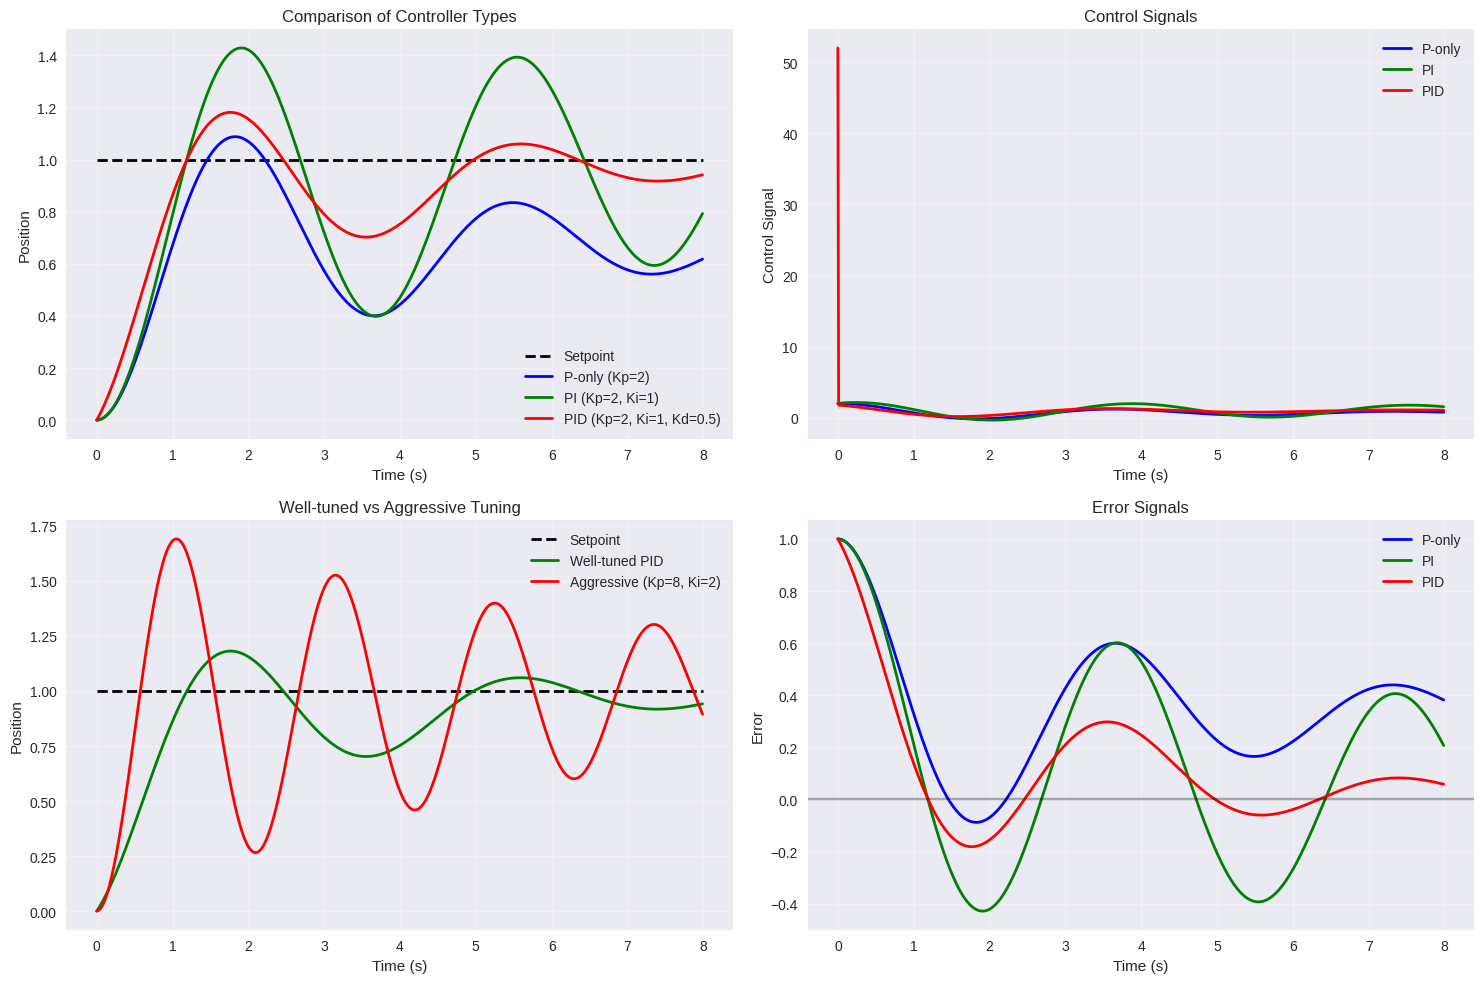

In [34]:
# Example 1: P-only control (Kp=2, Ki=0, Kd=0)
results_p = simulate_pid_control(Kp=2.0, Ki=0.0, Kd=0.0, setpoint=1.0, duration=8.0)

# Example 2: PI control (Kp=2, Ki=1, Kd=0)
results_pi = simulate_pid_control(Kp=2.0, Ki=1.0, Kd=0.0, setpoint=1.0, duration=8.0)

# Example 3: PID control (Kp=2, Ki=1, Kd=0.5)
results_pid = simulate_pid_control(Kp=2.0, Ki=1.0, Kd=0.5, setpoint=1.0, duration=8.0)

# Example 4: Overly aggressive (Kp=8, Ki=2, Kd=0)
results_aggressive = simulate_pid_control(Kp=8.0, Ki=2.0, Kd=0.0, setpoint=1.0, duration=8.0)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

time = results_p['time']

# Plot 1: Position responses
axes[0,0].plot(time, results_p['setpoint'], 'k--', label='Setpoint', linewidth=2)
axes[0,0].plot(time, results_p['position'], 'b-', label='P-only (Kp=2)', linewidth=2)
axes[0,0].plot(time, results_pi['position'], 'g-', label='PI (Kp=2, Ki=1)', linewidth=2)
axes[0,0].plot(time, results_pid['position'], 'r-', label='PID (Kp=2, Ki=1, Kd=0.5)', linewidth=2)
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Position')
axes[0,0].set_title('Comparison of Controller Types')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Control signals
axes[0,1].plot(time, results_p['control'], 'b-', label='P-only', linewidth=2)
axes[0,1].plot(time, results_pi['control'], 'g-', label='PI', linewidth=2)
axes[0,1].plot(time, results_pid['control'], 'r-', label='PID', linewidth=2)
axes[0,1].set_xlabel('Time (s)')
axes[0,1].set_ylabel('Control Signal')
axes[0,1].set_title('Control Signals')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Aggressive vs Well-tuned
axes[1,0].plot(time, results_pid['setpoint'], 'k--', label='Setpoint', linewidth=2)
axes[1,0].plot(time, results_pid['position'], 'g-', label='Well-tuned PID', linewidth=2)
axes[1,0].plot(time, results_aggressive['position'], 'r-', label='Aggressive (Kp=8, Ki=2)', linewidth=2)
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Position')
axes[1,0].set_title('Well-tuned vs Aggressive Tuning')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Error comparison
axes[1,1].plot(time, results_p['error'], 'b-', label='P-only', linewidth=2)
axes[1,1].plot(time, results_pi['error'], 'g-', label='PI', linewidth=2)
axes[1,1].plot(time, results_pid['error'], 'r-', label='PID', linewidth=2)
axes[1,1].set_xlabel('Time (s)')
axes[1,1].set_ylabel('Error')
axes[1,1].set_title('Error Signals')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## Key Observations

From the examples above, notice:

### P-only Controller
- **Fast initial response** but **steady-state error** remains
- Cannot eliminate offset error completely
- Simple but limited performance

### PI Controller  
- **Eliminates steady-state error** through integral action
- May have **more oscillation** than P-only
- Good for systems where accuracy is important

### PID Controller
- **Best overall performance**: fast response, no steady-state error, reduced oscillation
- D-term provides **damping** to reduce overshoot
- Most commonly used in practice

### Aggressive Tuning
- **High gains** can cause **instability and oscillation**
- **Conservative tuning** often better than aggressive
- Always test gradually when tuning real systems

## Practical Tuning Tips

1. **Start with P-only**: Increase Kp until you get reasonable speed without too much oscillation
2. **Add I-term**: Add Ki to eliminate steady-state error, but watch for oscillations
3. **Add D-term**: Add Kd to reduce overshoot and improve stability
4. **Fine-tune**: Make small adjustments and test each change
5. **Consider the application**: Some systems prioritize speed, others prioritize stability

## Try It Yourself!

**Exercise 1**: Use the interactive widget above to find PID gains that achieve:
- Settling time < 3 seconds
- Overshoot < 10%  
- Zero steady-state error

**Exercise 2**: What happens when you set:
- Kp = 0, Ki = 2, Kd = 0? (I-only control)
- Kp = 0, Ki = 0, Kd = 1? (D-only control)

**Exercise 3**: Try different setpoint values. How does the system respond to step changes?

## Summary

PID controllers are fundamental to control systems because they provide:
- **Simplicity**: Only 3 parameters to tune
- **Effectiveness**: Work well for most linear systems
- **Intuitive behavior**: Each term has a clear physical meaning
- **Wide applicability**: Used in everything from thermostats to spacecraft

The key to successful PID tuning is understanding the trade-offs between speed, stability, and accuracy, then adjusting the gains to meet your specific requirements.